## Anomaly Detection

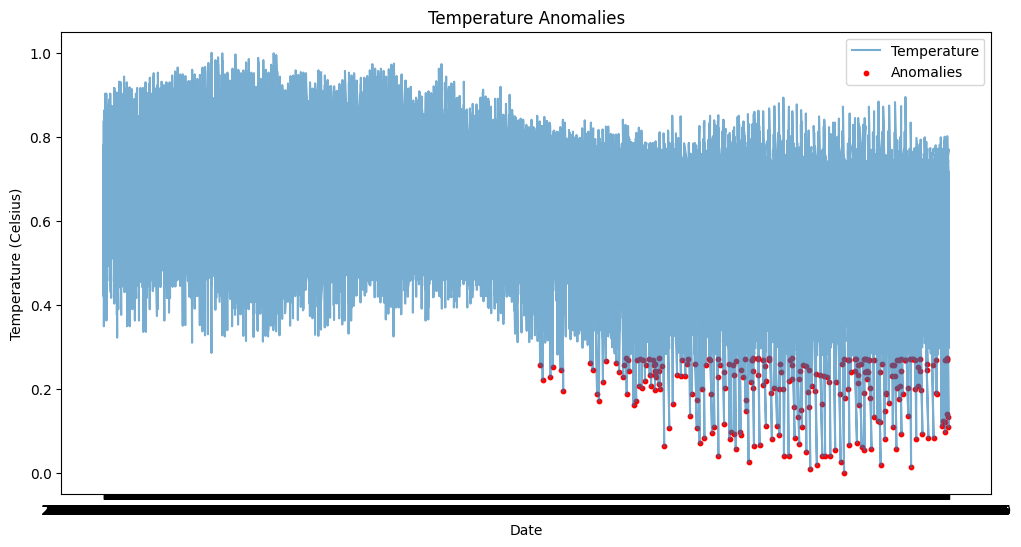

In [3]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load cleaned data
data = pd.read_csv(r'C:\users\shaurya\Downloads\weather_forecasting_project\data\processed\cleaned_weather_data.csv')

# Calculate Z-scores for temperature
data['z_score'] = zscore(data['temperature_celsius'])

# Define anomaly threshold (e.g., |Z-score| > 3)
anomalies = data[np.abs(data['z_score']) > 3]

# Visualize anomalies
plt.figure(figsize=(12, 6))
plt.plot(data['last_updated'], data['temperature_celsius'], label='Temperature', alpha=0.6)
plt.scatter(anomalies['last_updated'], anomalies['temperature_celsius'], color='red', label='Anomalies', s=10)
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.title('Temperature Anomalies')
plt.legend()
plt.show()

# Save anomalies for further analysis
anomalies.to_csv(r'C:\users\shaurya\Downloads\weather_forecasting_project\data\processed\temperature_anomalies.csv', index=False)


## Model Ensembles

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

# Prepare ARIMA data (use only time series)
df = data[['last_updated', 'temperature_celsius']]
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.set_index('last_updated', inplace=True)

# Train ARIMA model on training portion of the data
train_size = int(0.8 * len(df))
arima_train = df.iloc[:train_size]
arima_test = df.iloc[train_size:]  # Use this for ARIMA evaluation

arima_model = ARIMA(arima_train['temperature_celsius'], order=(5, 1, 0))
arima_fit = arima_model.fit()

# Generate ARIMA predictions for the test set range
arima_preds = arima_fit.forecast(steps=len(arima_test))

# Prepare XGBoost data
features = ['humidity', 'pressure_mb', 'wind_kph', 'precip_mm', 'cloud']
X = data[features]
y = data['temperature_celsius']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Generate XGBoost predictions for the test set
xgb_preds = xgb_model.predict(X_test)

# Align ARIMA predictions with XGBoost test set (ensure equal lengths)
aligned_arima_preds = arima_preds[:len(X_test)]

# Combine ARIMA and XGBoost predictions
ensemble_preds = (xgb_preds + aligned_arima_preds) / 2

# Evaluate ensemble model
mae = mean_absolute_error(y_test, ensemble_preds)
print(f"Ensemble MAE: {mae}")


C:\Users\SHAURYA\AppData\Local\Temp\ipykernel_28456\3050522411.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_updated'] = pd.to_datetime(df['last_updated'])
c:\Users\SHAURYA\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SHAURYA\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SHAURYA\AppData\Local\Progra

Ensemble MAE: 0.06784269788209762


## Feature Importance

c:\Users\SHAURYA\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 9703/9745 [00:20<00:00]        

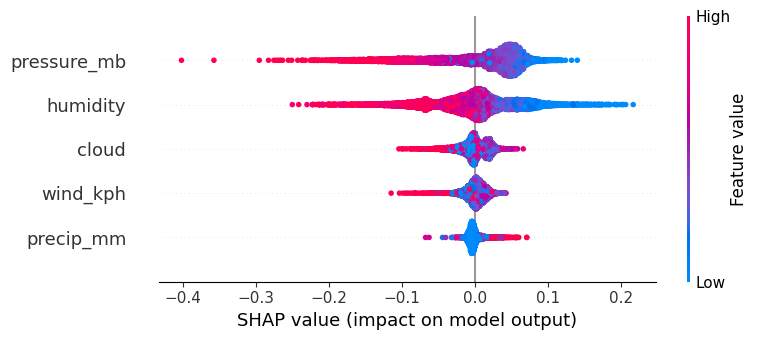

In [8]:
import shap

# Train XGBoost model with features
xgb_model.fit(X_train, y_train)

# Explain predictions with SHAP
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)

## Spatial Analysis

In [13]:
import geopandas as gpd
import folium
import pandas as pd

# Load the Natural Earth dataset
world = gpd.read_file(r"C:\users\shaurya\Downloads\weather_forecasting_project\data\raw\naturalearth_lowres\ne_110m_admin_0_countries.shp")

# Rename the 'ADMIN' column in the Natural Earth dataset to match the 'country' column in the weather data
world.rename(columns={'ADMIN': 'country'}, inplace=True)

# Ensure consistent country names in the weather dataset
data['country'] = data['country'].str.strip()

# Merge the datasets on the 'country' column
weather_geo = world.merge(data, how='left', on='country')

# Create an interactive map
weather_map = folium.Map(location=[20, 0], zoom_start=2)

# Add temperature data as markers on the map
for _, row in weather_geo.dropna(subset=['temperature_celsius']).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        fill=True,
        tooltip=f"{row['country']}: {row['temperature_celsius']}°C"
    ).add_to(weather_map)

# Save the map to an HTML file
weather_map.save(r'C:\users\shaurya\Downloads\weather_forecasting_project\visuals\plots\geographical_weather_map.html')
